In [35]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
plt.rcParams.update({'font.size': 18})
import utils
from LinearAlignment import LinearAlignment
from numpy import random

In [2]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise

    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id]


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [3]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [4]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    epoch_ind = data.columns.get_loc('epoch')
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data.iloc[0,epoch_ind])) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                j = data.index.get_loc(i)
                data = insert_previous_and_shift(data,feature,j)
    return data

In [5]:
def stretch_simulated_feats(data, stretch,true_feats = 'position',
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    if true_feats == 'position':
        true_feats_list = ['x','y','z']
    elif true_feats == 'velocity':
        true_feats_list = ['Vx','Vy','Vz']
    elif true_feats == 'all':
        true_feats_list = ['x','y','z'] + ['Vx','Vy','Vz']
    else:
        true_feats_list = true_feats
    
    for feature in true_feats_list:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

def amp_sim_feats(data, amp_stretch,feats = ['Vx_sim','Vy_sim','Vz_sim'],
                           suffix="_stretch_amp"):
    '''
    vary amplitude for simulation to better match true data,
    for a single sattelite;
    use predetermined amp_stretch coefficient (depends on the satellite)
    
    '''
    if feats == 'position':
        feats_list = ['x_sim','y_sim','z_sim']
    elif feats == 'velocity':
        feats_list = ['Vx_sim','Vy_sim','Vz_sim']
    elif feats == 'all':
        feats_list = ['x_sim','y_sim','z_sim'] + ['Vx_sim','Vy_sim','Vz_sim']
    else:
        feats_list = feats
        
    for feature in feats_list:
        data[feature+suffix] = amp_stretch*data[feature]
    
    return data

## Loading the data

In [53]:
data = pd.read_csv('data/train.csv', index_col = 'id')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
# data['epoch'] = data['epoch'] - data['epoch'][0]

In [54]:
#data.head(1)

In [55]:
test_data = pd.read_csv('data/test.csv', index_col = 'id')
test_data['time'] = test_data['epoch']
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)
# test_data['epoch'] = test_data['epoch'] - data['epoch'][0]

In [56]:
#test_data.head()

Track 1 train data only

In [57]:
sat_t1 = test_data['sat_id'].unique()
data = data[data['sat_id'].isin(sat_t1)]

In [58]:
all_data = pd.concat([data,test_data],sort=False)

In [59]:
train_index = data.index
test_index = test_data.index
all_index = all_data.index

In [60]:
target_list = ['x','y','z','Vx','Vy','Vz']
feature_list = [t+'_sim' for t in target_list]

### Remove time jumps: track 1

remove_time_jumps_fast on all track1 satellites only, compute smape

In [61]:
pd.options.mode.chained_assignment = None
remove_jumps = pd.DataFrame([])
for sat_id in tqdm(sat_t1):
    sat_data = get_satellite_data(all_data, sat_id)
    sat_data = remove_time_jumps_fast(sat_data)
    remove_jumps = remove_jumps.append(sat_data)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:38<00:00,  4.68it/s]


In [63]:
remove_jumps.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
id,,,,,,,,,,,,,,,,,
1819,1.388534e+18,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227,2014-01-01T00:00:00.000,0.000000,NaN
1820,1.388536e+18,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,-845.930363,-1.130992,5.822303,-3.250049,2014-01-01T00:21:11.845,0.014720,0.01472
1821,1.388537e+18,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,-4680.291877,-3.227356,4.123931,-2.700255,2014-01-01T00:42:23.690,0.029441,0.01472
1822,1.388538e+18,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,-7650.341207,-3.960215,2.520907,-1.976723,2014-01-01T01:03:35.534,0.044161,0.01472
1823,1.388539e+18,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,-9750.982621,-4.047005,1.297625,-1.347010,2014-01-01T01:24:47.379,0.058882,0.01472


In [64]:
remove_jumps_train = remove_jumps.drop('dt',axis=1).dropna()

In [65]:
remove_jumps_train.shape

(315183, 16)

In [66]:
remove_jumps_test = remove_jumps.loc[~remove_jumps.index.isin(remove_jumps.drop('dt',axis=1).dropna().index)]

In [67]:
remove_jumps_test.shape

(284071, 17)

In [68]:
remove_jumps_train.index.equals(data.index)

True

In [69]:
remove_jumps_test.index.equals(test_data.index)

True

In [70]:
smape_remove_jumps = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_train,sat)
    m = int(0.8*d.shape[0])
    smape_remove_jumps.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Add linear alignment
after having removed time jumps

In [75]:
sat_id = random.choice(sat_t1)
print(sat_id)
# sat_id = 448

128


In [76]:
alignment_model = LinearAlignment()
sat_data = get_satellite_data(remove_jumps, sat_id)
n_first = sat_data.shape[0] - sat_data['x'].isnull().sum()

index = sat_data.index
pred = pd.DataFrame(index = index)
sat_data.set_index(index)

n_train = 4*len(sat_data) // 10
train_sat_data = sat_data[:n_train]

pred['epoch'] = sat_data['epoch'].values
pred['t'] = sat_data['t'].values
pred['sat_id'] = sat_id

for feature_name in target_list:
    alignment_model.fit(t=train_sat_data['epoch'].values,
                        x=-train_sat_data[f'{feature_name}_sim'].values,
                        gt=-train_sat_data[feature_name].values)
    option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                 x=sat_data[f'{feature_name}_sim'].values)
    alignment_model.fit(t=train_sat_data['epoch'].values,
                        x= train_sat_data[f'{feature_name}_sim'].values,
                        gt= train_sat_data[feature_name].values)

    option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                 x=sat_data[f'{feature_name}_sim'].values)

    if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
        alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                        x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                        gt=-sat_data[feature_name].iloc[:n_first].values)

        pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                 x=sat_data[f'{feature_name}_sim'].values)
    else:
        alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                        x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                        gt=sat_data[feature_name].iloc[:n_first].values)
        pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                 x=sat_data[f'{feature_name}_sim'].values)

    pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values

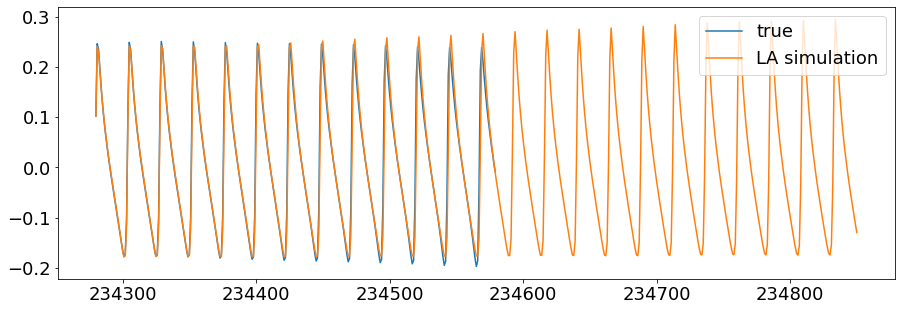

In [77]:
plt.figure(figsize=(15, 5));
plt.plot(pred['Vz'],label = 'true')
plt.plot(pred['Vz_sim'],label = 'LA simulation');
# plt.plot(get_satellite_data(test_data,sat_id)['Vz_sim'],label='test data simulation')
#plt.plot(a['Vx_sim'],label = 'prediction');
plt.legend();


In [51]:
pred.tail()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
901158,1.393598e+18,16129.601807,448,-430360.743034,NaN,1.467992e+07,NaN,881322.316863,NaN,-64.566644,NaN,514.442281,NaN,4.516417,NaN
901159,1.393605e+18,16129.688625,448,-429274.678725,NaN,1.465775e+07,NaN,879607.038850,NaN,-64.487737,NaN,513.370443,NaN,4.456037,NaN
901160,1.393613e+18,16129.775442,448,-428188.621119,NaN,1.463558e+07,NaN,877891.679547,NaN,-64.408826,NaN,512.298575,NaN,4.395657,NaN
901161,1.393620e+18,16129.862260,448,-427102.569925,NaN,1.461340e+07,NaN,876176.238495,NaN,-64.329911,NaN,511.226679,NaN,4.335277,NaN
901162,1.393628e+18,16129.949077,448,-426016.525434,NaN,1.459123e+07,NaN,874460.716151,NaN,-64.250991,NaN,510.154755,NaN,4.274897,NaN


In [20]:
alignment_model = LinearAlignment()
transf_df = pd.DataFrame([])
for sat_id in tqdm(sat_t1):

    sat_data = get_satellite_data(remove_jumps, sat_id)
    n_first = sat_data.shape[0] - sat_data['x'].isnull().sum()
    index = sat_data.index
    pred = pd.DataFrame(index = index)
    sat_data.set_index(index)

    n_train = 4*len(sat_data) // 10
    train_sat_data = sat_data[:n_train]
    
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:
        for feature_name in target_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)

            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=-sat_data[feature_name].iloc[:n_first].values)

                pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            else:
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=sat_data[feature_name].iloc[:n_first].values)
                pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values

    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    transf_df = transf_df.append(pred)

100%|██████████| 300/300 [02:37<00:00,  1.90it/s]


In [21]:
remove_jumps_la = transf_df.copy()
remove_jumps_la_train = remove_jumps_la.dropna()
remove_jumps_la_test = remove_jumps_la.loc[~remove_jumps_la.index.isin
                                           (remove_jumps_la.dropna().index)]

In [22]:
remove_jumps_la_train.index.equals(data.index)

True

In [23]:
remove_jumps_la_test.index.equals(test_data.index)

True

In [251]:
smape_remove_jumps_la = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_la_train,sat)
    m = int(0.8*d.shape[0])
    smape_remove_jumps_la.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

Check tails for all satellites, to be sure LA did not remove any data at end

In [25]:
#check tail on 372,587,523,473,515
import random
threshold = 0.0001
for i in sat_t1:
    if abs(get_satellite_data(remove_jumps_la,i)['Vx_sim'].tail(10).mean()) < threshold:
        print(i)

### Stretch horizontally

Will find one coefficient for x,y,z and another for Vx,Vy,Vz; that is best in terms of smape on train data.

In [ ]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [ ]:
stretch_dict_vel = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        d = stretch_simulated_feats(d,i,true_feats='velocity',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_vel[sat] = best[0]

In [ ]:
extreme_stretch = [k for k,v in stretch_dict_vel.items() if (v <= 0.98 or v >= 1.02)]
extreme_stretch

In [ ]:
for sat in extreme_stretch:
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.94,1.06,0.005):
        d = stretch_simulated_feats(d,i,true_feats = 'velocity')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_vel[sat] = best[0]

In [ ]:
extreme_stretch = [k for k,v in stretch_dict_vel.items() if (v <= 0.94 or v >= 1.06)]
extreme_stretch

In [26]:
#stretch_dict_vel = {int(k):v for k,v in stretch_dict_vel.items()}

#save stretch_dict
import json
#with open('stretch_dict_vel.txt', 'w') as file:
#    json.dump(stretch_dict_vel, file)

with open('stretch_dict_vel.txt', 'r') as file:
    stretch_dict_vel = json.load(file)

In [ ]:
#position
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]
stretch_dict_pos = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        d = stretch_simulated_feats(d,i,true_feats='position',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

In [ ]:
extreme_stretch = [k for k,v in stretch_dict_pos.items() if (v <= 0.98 or v >= 1.02)]
extreme_stretch

In [ ]:
for sat in extreme_stretch:
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.9,1.1,0.005):
        d = stretch_simulated_feats(d,i,true_feats = 'position')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

In [ ]:
extreme_stretch = [k for k,v in stretch_dict_pos.items() if (v <= 0.9 or v >= 1.1)]
extreme_stretch

In [27]:
#stretch_dict_pos = {int(k):v for k,v in stretch_dict_pos.items()}
#save stretch_dict
import json
#with open('stretch_dict_pos.txt', 'w') as file:
#    json.dump(stretch_dict_pos, file)

with open('stretch_dict_pos.txt', 'r') as file:
    stretch_dict_pos = json.load(file)

### Horizontal stretch after LA

In [ ]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [ ]:
stretch_dict_la_vel = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_la_train, sat)
    
    stretch_list = []
    for i in np.arange(0.95,1.05,0.005):
        d = stretch_simulated_feats(d,i,true_feats='velocity',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_la_vel[sat] = best[0]

In [ ]:
extreme_stretch = [k for k,v in stretch_dict_la_vel.items() if (v <= 0.95 or v >= 1.05)]
extreme_stretch

In [28]:
#stretch_dict_la_vel = {int(k):v for k,v in stretch_dict_la_vel.items()}
#save stretch_dict
import json
#with open('stretch_dict_la_vel.txt', 'w') as file:
#    json.dump(stretch_dict_la_vel, file)

with open('stretch_dict_la_vel.txt', 'r') as file:
    stretch_dict_la_vel = json.load(file)

In [ ]:
#position
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]
stretch_dict_la_pos = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_la_train, sat)
    
    stretch_list = []
    for i in np.arange(0.96,1.04,0.005):
        d = stretch_simulated_feats(d,i,true_feats='position',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_la_pos[sat] = best[0]

In [ ]:
extreme_stretch = [k for k,v in stretch_dict_la_pos.items() if (v <= 0.96 or v >= 1.04)]
extreme_stretch

In [29]:
#stretch_dict_la_pos = {int(k):v for k,v in stretch_dict_la_pos.items()}
#save stretch_dict
import json
#with open('stretch_dict_la_pos.txt', 'w') as file:
#    json.dump(stretch_dict_la_pos, file)

with open('stretch_dict_la_pos.txt', 'r') as file:
    stretch_dict_la_pos = json.load(file)

## Stretch amplitude, individually for each feature

In [ ]:
amp_dict_pos = {}
for dim in ['x','y','z']:
    amp_dict_pos[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

In [ ]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

In [ ]:
for dim in ['x','y','z']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

In [ ]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

In [30]:
#for dim in ['x','y','z']:
#    amp_dict_pos[dim] = {int(k):v for k,v in amp_dict_pos[dim].items()}
#save stretch_dict
import json
#with open('amp_dict_pos.txt', 'w') as file:
#    json.dump(amp_dict_pos, file)

with open('amp_dict_pos.txt', 'r') as file:
    amp_dict_pos = json.load(file)

In [ ]:
amp_dict_vel = {}
for dim in ['Vx','Vy','Vz']:
    amp_dict_vel[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_vel[dim][sat] = best[0]

In [ ]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_vel[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

In [ ]:
for dim in ['Vx','Vy','Vz']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_vel[dim][sat] = best[0]

In [ ]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_vel[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

In [31]:
#for dim in ['Vx','Vy','Vz']:
#    amp_dict_vel[dim] = {int(k):v for k,v in amp_dict_vel[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_vel.txt', 'w') as file:
#    json.dump(amp_dict_vel, file)

with open('amp_dict_vel.txt', 'r') as file:
    amp_dict_vel = json.load(file)

## Amplitude stretch after LA and horizontal stretch

In [ ]:
amp_dict_la_pos = {}
for dim in ['x','y','z']:
    amp_dict_la_pos[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_la_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_la_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_la_pos[dim][sat] = best[0]

In [ ]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_la_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

In [33]:
#for dim in ['x','y','z']:
#    amp_dict_la_pos[dim] = {int(k):v for k,v in amp_dict_la_pos[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_la_pos.txt', 'w') as file:
#    json.dump(amp_dict_la_pos, file)

with open('amp_dict_la_pos.txt', 'r') as file:
    amp_dict_la_pos = json.load(file)

In [ ]:
amp_dict_la_vel = {}
for dim in ['Vx','Vy','Vz']:
    amp_dict_la_vel[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_la_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_la_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_la_vel[dim][sat] = best[0]

In [ ]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_la_vel[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

In [32]:
#for dim in ['Vx','Vy','Vz']:
#    amp_dict_la_vel[dim] = {int(k):v for k,v in amp_dict_la_vel[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_la_vel.txt', 'w') as file:
#    json.dump(amp_dict_la_vel, file)

with open('amp_dict_la_vel.txt', 'r') as file:
    amp_dict_la_vel = json.load(file)

## Apply stretching to data


1. To `remove_jumps` df

2. Next, to `remove_jumps_la` df

In [34]:
df_list = [get_satellite_data(remove_jumps,i) for i in sat_t1]
len(df_list)

300

In [35]:
#horizontal stretch
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict_vel[str(int(df['sat_id'].unique()))],true_feats='velocity',suffix='_sim')
    df = stretch_simulated_feats(df,stretch_dict_pos[str(int(df['sat_id'].unique()))],true_feats='position',suffix='_sim')
df.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
id,,,,,,,,,,,,,,,,,
1231060,1.393565e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,77054.582572,-59078.354514,-568.800871,-0.803702,-1.297028,0.163600,2014-02-28T05:19:01.386,16129.221544,0.085244
1231061,1.393572e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,70256.332335,-67906.739391,638.268409,-1.037560,-1.095490,0.163476,2014-02-28T07:21:46.454,16129.306788,0.085244
1231062,1.393579e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,61829.238915,-75160.476673,1830.266511,-1.246389,-0.869204,0.159549,2014-02-28T09:24:31.522,16129.392032,0.085244
1231063,1.393587e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,51953.463644,-80650.378576,2978.927754,-1.431064,-0.616020,0.151705,2014-02-28T11:27:16.590,16129.477275,0.085244
1231064,1.393594e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,40809.611234,-84165.238391,4054.152281,-1.590525,-0.332080,0.139551,2014-02-28T13:30:01.658,16129.562519,0.085244


In [36]:
#amplitude stretch
for df in df_list:
    for dim in ['Vx','Vy','Vz']:
        #print(dim)
        amp = amp_dict_vel[dim][str(int(df['sat_id'].unique()))]
        #print(amp)
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
    for dim in ['x','y','z']:
        amp = amp_dict_pos[dim][str(int(df['sat_id'].unique()))]
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
df.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
id,,,,,,,,,,,,,,,,,
1231060,1.393565e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,77054.582572,-59078.354514,-568.800871,-0.803702,-1.297028,0.163600,2014-02-28T05:19:01.386,16129.221544,0.085244
1231061,1.393572e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,70256.332335,-67906.739391,638.268409,-1.037560,-1.095490,0.163476,2014-02-28T07:21:46.454,16129.306788,0.085244
1231062,1.393579e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,61829.238915,-75160.476673,1830.266511,-1.246389,-0.869204,0.159549,2014-02-28T09:24:31.522,16129.392032,0.085244
1231063,1.393587e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,51953.463644,-80650.378576,2978.927754,-1.431064,-0.616020,0.151705,2014-02-28T11:27:16.590,16129.477275,0.085244
1231064,1.393594e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,40809.611234,-84165.238391,4054.152281,-1.590525,-0.332080,0.139551,2014-02-28T13:30:01.658,16129.562519,0.085244


In [37]:
remove_jumps_stretch = pd.concat(df_list,axis=0,sort=False)

In [38]:
remove_jumps_stretch_train = remove_jumps_stretch.drop('dt',axis=1).dropna()

In [40]:
remove_jumps_stretch_test = remove_jumps_stretch.loc[~remove_jumps_stretch.index.isin
                                           (remove_jumps_stretch_train.dropna().index)]
remove_jumps_stretch_train.index.equals(data.index)
remove_jumps_stretch_test.index.equals(test_data.index)

True

In [252]:
smape_remove_jumps_stretch = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_stretch_train,sat)
    m = int(0.8*d.shape[0])
    smape_remove_jumps_stretch.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

Now LA and stretch

In [45]:
df_list = [get_satellite_data(remove_jumps_la,i) for i in sat_t1]
len(df_list)

300

In [46]:
#horizontal stretch
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict_la_vel[str(int(df['sat_id'].unique()))],true_feats='velocity',suffix='_sim')
    df = stretch_simulated_feats(df,stretch_dict_la_pos[str(int(df['sat_id'].unique()))],true_feats='position',suffix='_sim')
df.tail()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
1231060,1.393565e+18,16129.221544,597,3258.566123,NaN,-85222.214779,NaN,6865.804981,NaN,-1.564234,NaN,0.389517,NaN,-0.782024,NaN
1231061,1.393572e+18,16129.306788,597,-11090.238004,NaN,-85157.067499,NaN,7198.456304,NaN,-1.701828,NaN,0.796423,NaN,-0.917122,NaN
1231062,1.393579e+18,16129.392032,597,-25822.162385,NaN,-82556.771379,NaN,7284.971503,NaN,-1.811503,NaN,1.251472,NaN,-1.063917,NaN
1231063,1.393587e+18,16129.477275,597,-40755.890567,NaN,-77204.898038,NaN,7094.771615,NaN,-1.891778,NaN,1.758888,NaN,-1.222861,NaN
1231064,1.393594e+18,16129.562519,597,-55710.106089,NaN,-68885.019097,NaN,6597.277675,NaN,-1.941169,NaN,2.322894,NaN,-1.394404,NaN


In [47]:
#amplitude stretch
for df in df_list:
    for dim in ['Vx','Vy','Vz']:
        #print(dim)
        amp = amp_dict_la_vel[dim][str(int(df['sat_id'].unique()))]
        #print(amp)
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
    for dim in ['x','y','z']:
        amp = amp_dict_la_pos[dim][str(int(df['sat_id'].unique()))]
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]

In [48]:
df.tail()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
id,,,,,,,,,,,,,,,
1231060,1.393565e+18,16129.221544,597,3258.566123,NaN,-85222.214779,NaN,6865.804981,NaN,-1.564234,NaN,0.389517,NaN,-0.782024,NaN
1231061,1.393572e+18,16129.306788,597,-11090.238004,NaN,-85157.067499,NaN,7198.456304,NaN,-1.701828,NaN,0.796423,NaN,-0.917122,NaN
1231062,1.393579e+18,16129.392032,597,-25822.162385,NaN,-82556.771379,NaN,7284.971503,NaN,-1.811503,NaN,1.251472,NaN,-1.063917,NaN
1231063,1.393587e+18,16129.477275,597,-40755.890567,NaN,-77204.898038,NaN,7094.771615,NaN,-1.891778,NaN,1.758888,NaN,-1.222861,NaN
1231064,1.393594e+18,16129.562519,597,-55710.106089,NaN,-68885.019097,NaN,6597.277675,NaN,-1.941169,NaN,2.322894,NaN,-1.394404,NaN


In [49]:
remove_jumps_la_stretch = pd.concat(df_list,axis=0,sort=False)

In [52]:
remove_jumps_la_stretch_train = remove_jumps_la_stretch.dropna()

In [55]:
remove_jumps_la_stretch_test = remove_jumps_la_stretch.loc[~remove_jumps_la_stretch.index.isin
                                           (remove_jumps_la_stretch_train.dropna().index)]
remove_jumps_la_stretch_train.index.equals(data.index)
remove_jumps_la_stretch_test.index.equals(test_data.index)

True

In [253]:
smape_remove_jumps_la_stretch = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_la_stretch_train,sat)
    m = int(0.8*d.shape[0])
    smape_remove_jumps_la_stretch.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Smape for orignal simulation

In [254]:
smape_original = []
for sat in sat_t1:
    d = get_satellite_data(data,sat)
    m = int(0.8*d.shape[0])
    smape_original.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Remove jumps, stretch, then do LA

First two pieces already in `remove_jumps_stretch` df.

In [58]:
alignment_model = LinearAlignment()
stretch_la_df = pd.DataFrame([])
for sat_id in tqdm(sat_t1):
    try:
        sat_data = get_satellite_data(remove_jumps_stretch, sat_id)
        n_first = sat_data.shape[0] - sat_data['x'].isnull().sum()
        index = sat_data.index
        pred = pd.DataFrame(index = index)
        sat_data.set_index(index)
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    
    n_train = 4*len(sat_data) // 10
    train_sat_data = sat_data[:n_train]
    
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:
        for feature_name in target_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)

            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=-sat_data[feature_name].iloc[:n_first].values)

                pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            else:
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=sat_data[feature_name].iloc[:n_first].values)
                pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values

    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    stretch_la_df = stretch_la_df.append(pred)

100%|██████████| 300/300 [02:37<00:00,  1.91it/s]


In [59]:
remove_jumps_stretch_la_train = stretch_la_df.dropna()
remove_jumps_stretch_la_train.shape

(315183, 15)

In [63]:
remove_jumps_stretch_la_test = stretch_la_df.loc[~stretch_la_df.index.isin
                                           (remove_jumps_stretch_la_train.dropna().index)]
remove_jumps_stretch_la_train.index.equals(data.index)
#remove_jumps_stretch_la_test.index.equals(test_data.index)

True

In [255]:
smape_remove_jumps_stretch_la = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_stretch_la_train,sat)
    m = int(0.8*d.shape[0])
    smape_remove_jumps_stretch_la.append(smape(d[feature_list][m:].to_numpy(),d[target_list][m:].to_numpy()))

### Compare SMAPEs

Best choice `best_choice` of transformation for each satellite according to lowest smape in train data.

Code is: 

1. original data \
    `data` (train) and `test_data` (test) <hr>
    
2. yes remove time jumps \
    `remove_jumps_train` and `remove_jumps` <hr>
3. yes remove time jumps, yes LA \
    `remove_jumps_la_train` and `remove_jumps_la` <hr>
4. yes remove time jumps, yes LA, yes stretch (in that order) \
    `remove_jumps_la_stretch_train` and `remove_jumps_la_stretch` <hr>
5. yes remove time jumps, yes stretch \
    `remove_jumps_stretch_train` and `remove_jumps_stretch` <hr>
6. yes remove time jumps, yes stretch, yes LA (in that order) \
    `stretch_la_df_train` and `stretch_la_df`

In [256]:
satellites_and_smapes = [sat_t1, smape_original,smape_remove_jumps,smape_remove_jumps_la,
                        smape_remove_jumps_la_stretch,smape_remove_jumps_stretch,
                        smape_remove_jumps_stretch_la]

In [257]:
smapes_all = list(zip(sat_t1, smape_original,smape_remove_jumps,smape_remove_jumps_la,
                        smape_remove_jumps_la_stretch,smape_remove_jumps_stretch,
                        smape_remove_jumps_stretch_la))
len(smapes_all)

300

In [258]:
best_choice = []
for i in range(len(sat_t1)):
    best_choice.append((smapes_all[i][0],smapes_all[i].index(min(smapes_all[i]))))

## Submission with best transformation by satellite

In [275]:
best_choice_map = {1:test_data,2:remove_jumps_test,3:remove_jumps_la_test,
                   4:remove_jumps_la_stretch_test,5:remove_jumps_stretch_test,
                   6:remove_jumps_stretch_la_test}

In [282]:
d = best_choice_map[best_choice[0][1]][feature_list+['sat_id']]
d = d[d['sat_id']==1]
d

,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,sat_id
id,,,,,,,
3927,3.451926e+03,1.779933e+04,3.366995e+02,-2.691213e+00,-44.969238,4.665829,1
3928,-1.996347e+03,1.658668e+04,2.028978e+03,-2.214549e+00,-44.581163,4.527994,1
3929,-7.308540e+03,1.485932e+04,3.658199e+03,-1.730742e+00,-44.193086,4.390158,1
3930,-1.221063e+04,1.273223e+04,5.151846e+03,-1.239416e+00,-43.805007,4.252321,1
3931,-1.658949e+04,1.029620e+04,6.403683e+03,-7.381428e-01,-43.416926,4.114484,1
...,...,...,...,...,...,...,...
5823,-1.083020e+08,5.136975e+09,-1.418074e+10,-1.718221e+06,4.496728,1.246372,1
5824,-1.095528e+08,5.173706e+09,-1.424009e+10,-1.729258e+06,2.689731,1.152931,1
5825,-1.108131e+08,5.210612e+09,-1.429961e+10,-1.740341e+06,1.324530,0.995561,1


In [315]:
submission_best_transformation = pd.DataFrame([])
i=0
for sat in sat_t1:
  #  if i < 1:
   #     print(i, best_choice[i][1])
    d = best_choice_map[best_choice[i][1]][feature_list+['sat_id']]
   # if i < 1:
   #     print(d.shape)
    d = d[d['sat_id']==sat]
   # if i < 1:
    #    print(d[feature_list].columns)
    submission_best_transformation = submission_best_transformation.append(d)
    #if i < 1:
     #   print(submission_best_transformation.shape)
    i += 1

In [289]:
submission_best_transformation.drop('sat_id',axis=1,inplace=True)
submission_best_transformation.head()

,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,
3927,3451.926397,17799.333691,336.699534,-2.691213,-44.969238,4.665829
3928,-1996.347386,16586.678857,2028.978297,-2.214549,-44.581163,4.527994
3929,-7308.539847,14859.319228,3658.198746,-1.730742,-44.193086,4.390158
3930,-12210.632339,12732.228697,5151.846398,-1.239416,-43.805007,4.252321
3931,-16589.490670,10296.198786,6403.683205,-0.738143,-43.416926,4.114484


In [262]:
submission_best_transformation.shape[0] - test_data.shape[0]

0

In [290]:
submission_best_transformation.index.equals(test_data.index)

True

32 (32, 4)


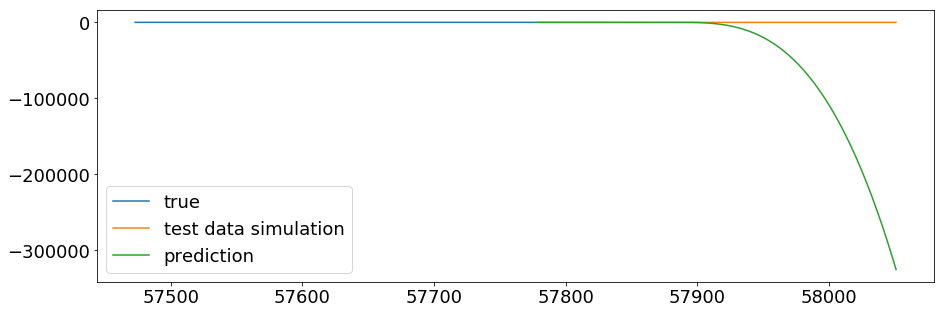

In [583]:
import random
sat = random.choice(sat_t1)
t = get_satellite_data(test_data,sat)
a = get_satellite_data(submission_best_transformation,sat)
b = get_satellite_data(data,sat) 
print(sat,best_choice[list(sat_t1).index(sat)])
plt.figure(figsize=(15, 5));
plt.plot(b['Vx'],label = 'true')
plt.plot(t['Vx_sim'],label = 'test data simulation');
plt.plot(a['Vx_sim'],label = 'prediction');
plt.legend();


In [474]:
submission_best_transformation.columns = target_list
submission_best_transformation.head()

ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

In [292]:
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
submission_best_transformation.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2020-02-02_14-53-56.csv


Check correctness of submission file

In [293]:
i = 0
for sat in sat_t1:
    ind = get_satellite_data(test_data,sat).index
    df = submission_best_transformation
    sub = df[df.index.isin(ind)]
    b = best_choice_map[best_choice[i][1]]
    sub2 = b[b.index.isin(ind)]
    if sub.shape[0] != sub2.shape[0]:
        print('Length does not match for satellite:',sat)
    for dim in target_list:
        if sub[dim].equals(other = sub2[dim +'_sim']) == False:
            print(sat,dim)    
    i+=1   
#if correcly matched best transformation, expect no output here

In [301]:
td = remove_jumps_la_stretch_test[feature_list]
ta = test_data[feature_list]

In [302]:
td.columns = target_list
ta.columns = target_list

In [296]:
smape(ta,td)

x     0.734760
y     0.757875
z     0.729021
Vx    0.751220
Vy    0.755115
Vz    0.773127
dtype: float64

In [273]:
#seems incorrect (high smape): 
#remove_jumps_la_stretch_test, 
#remove_jumps_stretch_la_test
#remove_jumps_la_test

#seems correct (lower smape):
#remove_jumps_stretch_test
#remove_jumps_test
#

In [310]:
td = pd.read_csv('submission_2020-02-02_13-35-01.csv',index_col='id')

In [311]:
td.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,3451.926397,17799.333691,336.699534,-2.691213,-44.969238,4.665829
3928,-1996.347386,16586.678857,2028.978297,-2.214549,-44.581163,4.527994
3929,-7308.539847,14859.319228,3658.198746,-1.730742,-44.193086,4.390158
3930,-12210.632339,12732.228697,5151.846398,-1.239416,-43.805007,4.252321
3931,-16589.490670,10296.198786,6403.683205,-0.738143,-43.416926,4.114484


In [312]:
smape(td,ta)

x     0.629777
y     0.661242
z     0.640883
Vx    0.648419
Vy    0.657030
Vz    0.661540
dtype: float64

In [297]:
#average smape for entire train data
sum([min(smapes_all[i]) for i in range(300)])/300

0.07890955071912191

## Train test split

Now split the train data set to train/test for RF model.

In [ ]:
def train_test_split(df,col = 'sat_id',ratio = 0.8,targets = ['x','y','z','Vx','Vy','Vz']):
    '''
    train test split for our train data, 
    default, 80% train for each satellite, 20% test
    '''
    sat_list = df[col].unique()
    train_df = pd.DataFrame([])
    test_df = pd.DataFrame([])
    for sat in sat_list:
        sat_df = get_satellite_data(df,sat)
        n = int(ratio*sat_df.shape[0])
        train_df = train_df.append(sat_df[:n])
        test_df = test_df.append(sat_df[n:])
    Y_train = train_df[targets]
    Y_test = test_df[targets]
    X_train = train_df.drop(targets,axis=1)
    X_test = test_df.drop(targets,axis=1)
    return X_train, X_test, Y_train, Y_test       

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data)

In [ ]:
#checking indices match
for sat in X_train['sat_id'].unique():
    if X_train[X_train['sat_id']==sat].index[-1] + 1 != X_test[X_test['sat_id']==sat].index[0]:
        print(sat)

In [ ]:
(Y_test.index != X_test.index).sum()

In [ ]:
(Y_train.index != X_train.index).sum()

### Random forest

First remove time jumps and run linear alignment on train data.

In [ ]:
sat_track1 = test_data['sat_id'].unique()

In [ ]:
features_list
feat_sim = [feat+'_sim' for feat in features_list]
feat_sim

In [ ]:
data2 = transf_df.copy()
#print('shape',data2.shape)
for feat in feat_sim:
    data2[feat+'_shift'] = data2.groupby(['sat_id'])[feat].shift()
    #print('shape',data2.shape)
    data2[feat+'_diff'] = data2.groupby(['sat_id'])[feat].diff()
    #print('shape',data2.shape)
data2 = data2.fillna(0)
#print(data2.isna().sum())
#print('shape',data2.shape)
data2.head()

In [ ]:
no_la = [] #exclude from LA
#no_la = [372,587,523,473,514] #satellites excluded from LA by Tanya
la_list = [s for s in satellites_list if s not in no_la]
len(la_list)

Train separate model for each of 6 predictors:

In [ ]:
transf_df.shape

## Try VAR, first check stationarity with Augmented Dickey-Fuller test

In [ ]:
data.shape

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = data[data['sat_id']==0]['x'].to_numpy()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [ ]:
sub = pd.read_csv('data/submission.csv')

In [ ]:
sub_index = sub.id.values
sub.head()

In [ ]:
q = transf_df.loc[sub_index,['x_sim', 'y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]
q.columns = ['x','y','z','Vx','Vy','Vz']
# q = q.reset_index()
q.head()

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(sub.x.iloc[2500:2900].values)

plt.plot(q.x.iloc[2500:2900].values)

In [ ]:
import datetime

submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
q.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

q.head(10)

### Period

In [ ]:
def cycle_lengths(t,x):
    '''
    Find cycle lengths; input t = time array or series and x = position or velocity
    '''
    spl = InterpolatedUnivariateSpline(t, x)
    roots = spl.roots()
    half_periods = np.diff(spl.roots())
    periods = np.add.reduceat(half_periods, np.arange(0, len(half_periods), 2))
    if len(half_periods)%2 != 0: #if odd # of observations, remove last (invalid) half period
        periods = periods[:-1]
    return periods

In [ ]:
d = data[data.sat_id == 317]
td = test_data[test_data.sat_id == 317]
new = pd.concat([d,td],  axis = 0, sort = False)
spl = InterpolatedUnivariateSpline(d['epoch'], d['x'])
roots = spl.roots()
plt.figure(figsize=(15, 5))
#plt.plot(new['epoch'],new['x_sim'])
plt.plot(d['epoch'],d['x'])
plt.scatter(roots,[0]*len(roots));

In [ ]:
d = data[data.sat_id == 302]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig = plt.figure()
fig.add_subplot(321)
plt.plot(periods);

d = data[data.sat_id == 303]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(322)
plt.plot(periods);

d = data[data.sat_id == 304]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(323)
plt.plot(periods);

d = data[data.sat_id == 305]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(324)
plt.plot(periods);

d = data[data.sat_id == 306]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(325)
plt.plot(periods);

d = data[data.sat_id == 307]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(326)
plt.plot(periods);

plt.subplots_adjust(top=2.92, bottom=0.08, left=0.30, right=1.95, hspace=0.25,
                    wspace=0.35)

plt.show();